In [1]:
model_name = 'Mode_Global'
mode_num = 0
mode_range = 20

In [2]:
import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt

In [3]:
raw_train = np.load('../Grid_LSTM/POD/train_z500_coeffs.npy').T[:,:20]
raw_test = np.load('../Grid_LSTM/POD/train_z500_coeffs.npy').T[:,:20]

In [4]:
scaler = MinMaxScaler()
train_coeffs = scaler.fit_transform(raw_train)
test_coeffs = scaler.transform(raw_test)

In [5]:
input_window = 14
output_window = 7

train_inputs = []
train_outputs = []

i = 0
while i < train_coeffs.shape[0] - input_window - output_window:
    train_inputs.append(train_coeffs[i:i+input_window])
    train_outputs.append(train_coeffs[i+input_window:i+input_window+output_window])
    i = i + 1
    
train_inputs = np.asarray(train_inputs)
train_outputs = np.asarray(train_outputs)[:,:,mode_num:mode_num+mode_range]

In [6]:
embed_dim = train_inputs[0].shape[-1]
output_dim = train_outputs[0].shape[-1]

In [7]:
ff_dim = 50  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0

inputs = layers.Input(shape=(input_window,embed_dim))
lstm_layer_1 = layers.Bidirectional(layers.LSTM(ff_dim,activation='relu'))
lstm_layer_2 = layers.RepeatVector(output_window)
lstm_layer_3 = layers.Bidirectional(layers.LSTM(ff_dim,return_sequences=True,activation='relu'))
layer_out = layers.TimeDistributed(layers.Dense(output_dim))

x = lstm_layer_1(inputs)
x = lstm_layer_2(x)
x = lstm_layer_3(x)
outputs = layer_out(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss',patience=20)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 20)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               28400     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 100)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 100)            60400     
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 20)             2020      
Total params: 90,820
Trainable params: 90,820
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_inputs,train_outputs,epochs=40,batch_size=256,callbacks=[reduce_lr,early_stop],validation_split=0.2)

Epoch 1/40
40/40 [==============================] - 1s 25ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 2/40
40/40 [==============================] - 1s 24ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 3/40
40/40 [==============================] - 1s 23ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 4/40
40/40 [==============================] - 1s 24ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 5/40
40/40 [==============================] - 1s 23ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 6/40
40/40 [==============================] - 1s 22ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 7/40
40/40 [==============================] - 1s 22ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 8/40
40/40 [==============================] - 1s 24ms/step - loss: 0.0118 - val_loss: 0.0121
Epoch 9/40
40/40 [==============================] - 1s 23ms/step - loss: 0.0118 - val_loss: 0.0120
Epoch 10/40
40/40 [==============================] - 1s 25ms/step - loss: 0.0118 - val_loss: 0.0121
Epoch 11/

In [14]:
pred_outputs = model.predict(train_inputs)

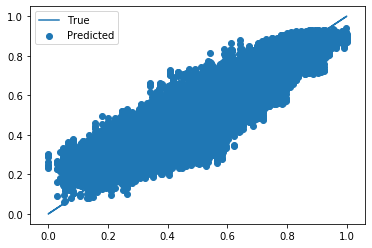

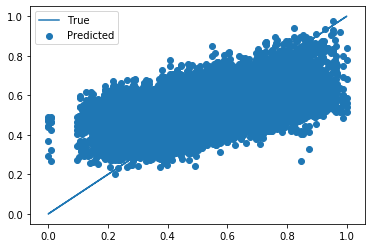

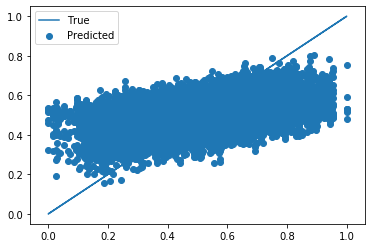

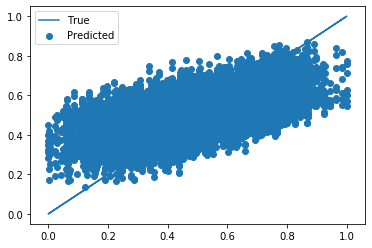

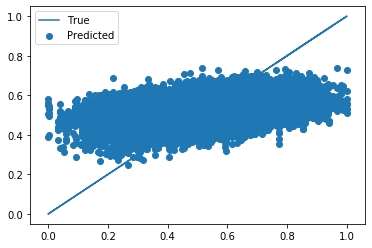

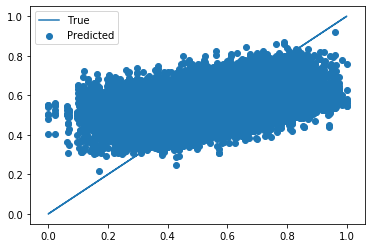

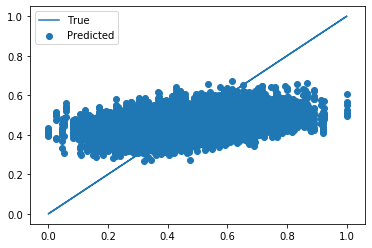

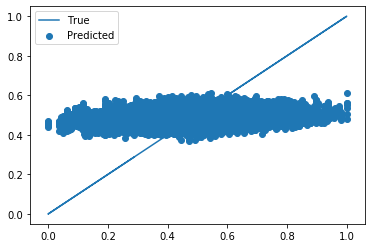

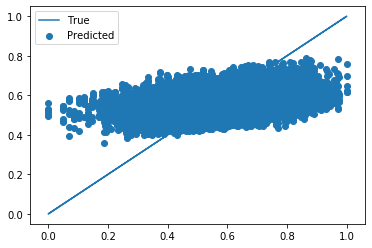

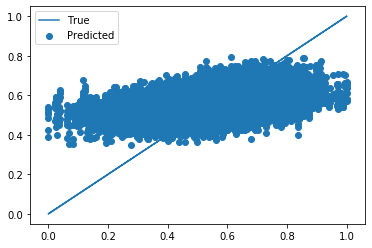

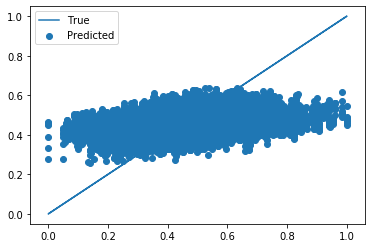

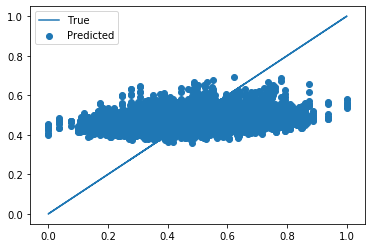

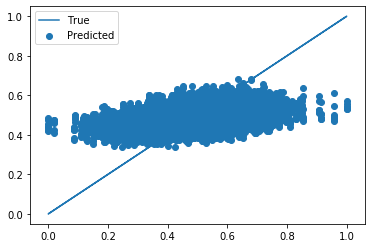

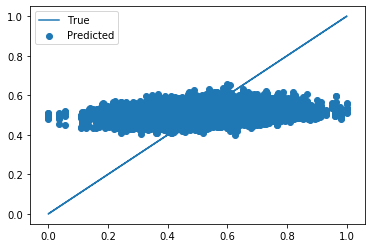

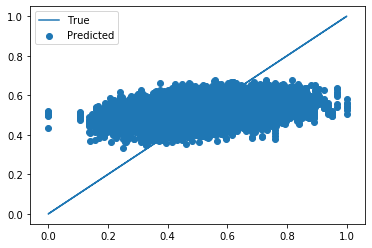

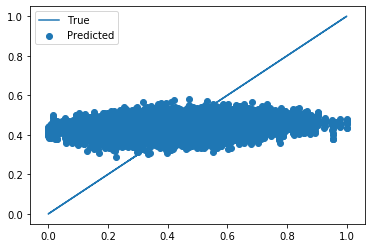

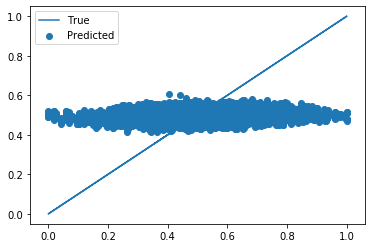

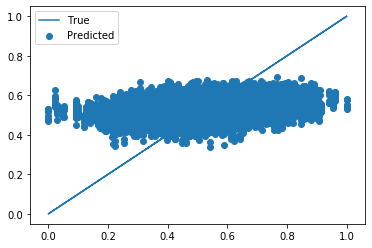

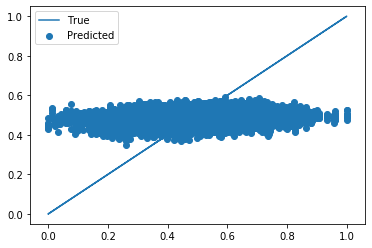

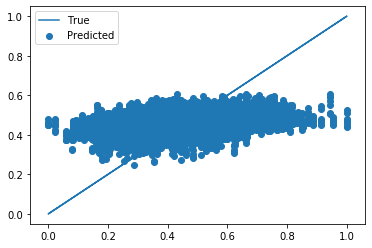

In [16]:
for mode_num in range(20):
    plt.figure()
    plt.plot(train_outputs[:,:,mode_num].flatten(),train_outputs[:,:,mode_num].flatten(),label='True')
    plt.scatter(train_outputs[:,:,mode_num].flatten(),pred_outputs[:,:,mode_num].flatten(),label='Predicted')
    plt.legend()
    plt.show()